# Water Body Semantic Segmentation
### 12-band Multispectral Satellite Pipeline — Pure TensorFlow

**Architecture:** U-Net with ResNet34-style encoder (built from scratch in TensorFlow/Keras)  
**Data:** 12-band GeoTIFF images + binary water masks (0=background, 1=water)  
**Framework:** TensorFlow 2.x / Keras

Pipeline steps:
1. Data inspection and cleaning
2. Band importance analysis — identify the most discriminative bands for water detection
3. Model training using only the selected important bands
4. Inference, visualization, and evaluation

## Install Packages

In [1]:
%pip install rasterio opencv-python-headless matplotlib numpy pandas scikit-learn scipy -q

## Import Libraries

In [2]:
import os
import time
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from matplotlib.patches import Patch
from scipy.ndimage import gaussian_filter

import cv2
import rasterio

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

print(f"TensorFlow version : {tf.__version__}")
print(f"GPU available      : {len(tf.config.list_physical_devices('GPU')) > 0}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPU devices        : {[g.name for g in gpus]}")

TensorFlow version : 2.19.0
GPU available      : True
GPU devices        : ['/physical_device:GPU:0']


## Mount Google Drive and Locate Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -o "/content/drive/MyDrive/satellite_data.zip" -d "/content/satellite_data"

Archive:  /content/drive/MyDrive/satellite_data.zip
  inflating: /content/satellite_data/data/images/2.tif  
  inflating: /content/satellite_data/data/images/298.tif  
  inflating: /content/satellite_data/data/images/297.tif  
  inflating: /content/satellite_data/data/images/303.tif  
  inflating: /content/satellite_data/data/images/302.tif  
  inflating: /content/satellite_data/data/images/301.tif  
  inflating: /content/satellite_data/data/images/300.tif  
  inflating: /content/satellite_data/data/images/305.tif  
  inflating: /content/satellite_data/data/images/304.tif  
  inflating: /content/satellite_data/data/images/288.tif  
  inflating: /content/satellite_data/data/images/294.tif  
  inflating: /content/satellite_data/data/images/296.tif  
  inflating: /content/satellite_data/data/images/291.tif  
  inflating: /content/satellite_data/data/images/287.tif  
  inflating: /content/satellite_data/data/images/299.tif  
  inflating: /content/satellite_data/data/images/295.tif  
  infl

In [5]:
IMAGES_DIR = '/content/satellite_data/data/images'
LABELS_DIR = '/content/satellite_data/data/labels'
OUTPUT_DIR = '/content/satellite_data/unet_models'
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

images = sorted([f for f in os.listdir(IMAGES_DIR) if f.endswith('.tif')])
labels = sorted([f for f in os.listdir(LABELS_DIR) if f.endswith(('.png', '.tif'))])
print(f"Found {len(images)} images and {len(labels)} labels")
print(f"Sample images : {images[:3]}")
print(f"Sample labels : {labels[:3]}")

Found 306 images and 456 labels
Sample images : ['0.tif', '1.tif', '10.tif']
Sample labels : ['0.png', '1.png', '10.png']


## Inspect and Clean Data

In [6]:
img_stems = {p.stem for p in Path(IMAGES_DIR).glob('*.tif')}
lbl_stems = {p.stem for p in Path(LABELS_DIR).glob('*.png') if '_' not in p.stem}

print(f"Images   : {len(img_stems)}")
print(f"Labels   : {len(lbl_stems)}")
print(f"Matched  : {len(img_stems & lbl_stems)}")
print(f"Imgs without label : {sorted(img_stems - lbl_stems)[:5]}")
print(f"Lbls without image : {sorted(lbl_stems - img_stems)[:5]}")

Images   : 306
Labels   : 306
Matched  : 306
Imgs without label : []
Lbls without image : []


In [7]:
sample_img = sorted(Path(IMAGES_DIR).glob('*.tif'))[0]
with rasterio.open(sample_img) as src:
    print(f"Image  : {sample_img.name}")
    print(f"Bands  : {src.count}")
    print(f"Size   : {src.width} x {src.height}")
    print(f"Dtype  : {src.dtypes[0]}")
    arr = src.read()
    print(f"Min/Max: {arr.min():.4f} / {arr.max():.4f}")

sample_lbl = sorted(Path(LABELS_DIR).glob('*.png'))[0]
mask_check = cv2.imread(str(sample_lbl), cv2.IMREAD_GRAYSCALE)
print(f"\nMask unique values : {np.unique(mask_check)}")

Image  : 0.tif
Bands  : 12
Size   : 128 x 128
Dtype  : int16
Min/Max: -28.0000 / 4975.0000

Mask unique values : [0 1]


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:367: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)


In [38]:
IMAGES_CLEAN = '/content/satellite_data/images_clean'
LABELS_CLEAN = '/content/satellite_data/labels_clean'
Path(IMAGES_CLEAN).mkdir(parents=True, exist_ok=True)
Path(LABELS_CLEAN).mkdir(parents=True, exist_ok=True)

## Band Importance Analysis

Before training the segmentation model, we run three complementary tests across
all 12 bands to identify which carry the most discriminative signal for water
versus background. The model is then trained using only those bands.

### Method 1 — Statistical separability
For each band, compute the normalised difference between the water-pixel mean
and the background-pixel mean (divided by the sum of their standard deviations).
A high value means the two classes are well separated in that band.

### Method 2 — Random Forest Gini importance
A Random Forest classifier is trained on balanced pixel samples. The Gini
impurity decrease attributed to each band is used as an importance score.

### Method 3 — Mutual information
A non-parametric estimator of how much knowing a band value reduces uncertainty
about the water label (higher = more informative).

The three normalised scores are averaged into a consensus ranking. Bands
covering the top 80% of total score are kept for training (capped at 8 bands,
minimum 3).

In [9]:
# Pixel sampling for band analysis
N_ANALYSIS_IMAGES = 80    # images to sample from
PIXELS_PER_IMAGE  = 300   # balanced pixels per image
NUM_BANDS_TOTAL   = 12

analysis_imgs = sorted(Path(IMAGES_CLEAN).glob('*.tif'))
rng = np.random.default_rng(42)

X_pixels = []
y_pixels = []

print(f"Sampling pixels from {min(N_ANALYSIS_IMAGES, len(analysis_imgs))} images...")

for img_path in analysis_imgs[:N_ANALYSIS_IMAGES]:
    lbl_path = Path(LABELS_CLEAN) / (img_path.stem + '.png')
    if not lbl_path.exists():
        continue

    with rasterio.open(img_path) as src:
        arr = src.read().astype(np.float32)   # (12, H, W)

    mask_img = cv2.imread(str(lbl_path), cv2.IMREAD_GRAYSCALE)
    mask_img = (mask_img > 0).astype(np.uint8)

    arr_hw  = np.transpose(arr, (1, 2, 0))          # (H, W, 12)
    flat_x  = arr_hw.reshape(-1, NUM_BANDS_TOTAL)   # (H*W, 12)
    flat_y  = mask_img.ravel()                       # (H*W,)

    water_idx = np.where(flat_y == 1)[0]
    bg_idx    = np.where(flat_y == 0)[0]
    n_each    = min(PIXELS_PER_IMAGE // 2, len(water_idx), len(bg_idx))
    if n_each == 0:
        continue

    idx = np.concatenate([
        rng.choice(water_idx, n_each, replace=False),
        rng.choice(bg_idx,    n_each, replace=False),
    ])
    X_pixels.append(flat_x[idx])
    y_pixels.append(flat_y[idx])

X_pixels = np.vstack(X_pixels)
y_pixels = np.concatenate(y_pixels)

print(f"Total pixels   : {len(y_pixels):,}")
print(f"Water pixels   : {y_pixels.sum():,}  ({100*y_pixels.mean():.1f}%)")
print(f"Background     : {(1-y_pixels).sum():,}")

Sampling pixels from 80 images...
Total pixels   : 18,792
Water pixels   : 9,396  (50.0%)
Background     : 9,396


In [10]:
# Method 1: Statistical separability
water_mask = y_pixels == 1
bg_mask    = y_pixels == 0
band_names = [f'B{i+1}' for i in range(NUM_BANDS_TOTAL)]

sep_scores = []
for b in range(NUM_BANDS_TOTAL):
    w = X_pixels[water_mask, b]
    g = X_pixels[bg_mask,    b]
    score = abs(w.mean() - g.mean()) / (w.std() + g.std() + 1e-8)
    sep_scores.append(score)

sep_scores = np.array(sep_scores)
sep_norm   = sep_scores / sep_scores.sum()

df_sep = pd.DataFrame({'band': band_names, 'separability': sep_norm})
print("Statistical separability (normalised):")
print(df_sep.sort_values('separability', ascending=False).to_string(index=False))

Statistical separability (normalised):
band  separability
  B5      0.172234
  B6      0.166574
 B12      0.162893
  B7      0.133098
 B11      0.114206
  B8      0.062684
  B1      0.052188
  B2      0.044228
  B3      0.033201
  B4      0.027659
  B9      0.023983
 B10      0.007053


In [11]:
# Method 2: Random Forest feature importance
print("Training Random Forest on pixel samples...")

scaler   = StandardScaler()
X_scaled = scaler.fit_transform(X_pixels)

rf = RandomForestClassifier(
    n_estimators = 200,
    max_depth    = 12,
    n_jobs       = -1,
    random_state = 42,
    class_weight = 'balanced',
    oob_score    = True,
)
rf.fit(X_scaled, y_pixels)

rf_imp      = rf.feature_importances_
rf_imp_norm = rf_imp / rf_imp.sum()

df_rf = pd.DataFrame({'band': band_names, 'rf_importance': rf_imp_norm})
print(f"RF OOB accuracy : {rf.oob_score_:.4f}")
print("\nRandom Forest importance (normalised):")
print(df_rf.sort_values('rf_importance', ascending=False).to_string(index=False))

Training Random Forest on pixel samples...
RF OOB accuracy : 0.8621

Random Forest importance (normalised):
band  rf_importance
  B6       0.213807
  B5       0.154314
  B7       0.133632
 B11       0.101588
  B9       0.096463
 B10       0.082256
 B12       0.075533
  B3       0.031873
  B1       0.030311
  B4       0.030138
  B2       0.025483
  B8       0.024603


In [12]:
# Method 3: Mutual information
print("Computing mutual information...")

mi_scores = mutual_info_classif(
    X_pixels, y_pixels,
    discrete_features = False,
    n_neighbors       = 5,
    random_state      = 42,
)
mi_norm = mi_scores / (mi_scores.sum() + 1e-12)

df_mi = pd.DataFrame({'band': band_names, 'mutual_info': mi_norm})
print("Mutual information (normalised):")
print(df_mi.sort_values('mutual_info', ascending=False).to_string(index=False))

Computing mutual information...
Mutual information (normalised):
band  mutual_info
  B9     0.127777
 B10     0.127382
  B5     0.122823
  B6     0.119677
  B7     0.109182
  B8     0.108200
 B12     0.096879
 B11     0.093656
  B4     0.026190
  B1     0.025115
  B2     0.024245
  B3     0.018875


In [13]:
# Combine all three methods into a consensus ranking
sep_s = df_sep.set_index('band')['separability']
rf_s  = df_rf.set_index('band')['rf_importance']
mi_s  = df_mi.set_index('band')['mutual_info']

consensus = pd.DataFrame({'band': band_names})
consensus['separability']   = consensus['band'].map(sep_s)
consensus['rf_importance']  = consensus['band'].map(rf_s)
consensus['mutual_info']    = consensus['band'].map(mi_s)
consensus['consensus_score'] = (
    consensus['separability'] +
    consensus['rf_importance'] +
    consensus['mutual_info']
) / 3.0

consensus = consensus.sort_values('consensus_score', ascending=False).reset_index(drop=True)
consensus['rank'] = range(1, len(consensus) + 1)

print("=" * 72)
print("BAND IMPORTANCE CONSENSUS RANKING")
print("=" * 72)
print(consensus[['rank', 'band', 'separability', 'rf_importance',
                  'mutual_info', 'consensus_score']].to_string(index=False))

BAND IMPORTANCE CONSENSUS RANKING
 rank band  separability  rf_importance  mutual_info  consensus_score
    1   B6      0.166574       0.213807     0.119677         0.166686
    2   B5      0.172234       0.154314     0.122823         0.149790
    3   B7      0.133098       0.133632     0.109182         0.125304
    4  B12      0.162893       0.075533     0.096879         0.111768
    5  B11      0.114206       0.101588     0.093656         0.103150
    6   B9      0.023983       0.096463     0.127777         0.082741
    7  B10      0.007053       0.082256     0.127382         0.072230
    8   B8      0.062684       0.024603     0.108200         0.065163
    9   B1      0.052188       0.030311     0.025115         0.035871
   10   B2      0.044228       0.025483     0.024245         0.031319
   11   B4      0.027659       0.030138     0.026190         0.027996
   12   B3      0.033201       0.031873     0.018875         0.027983


In [14]:
# Select bands that together cover >= 80% of total consensus score
COVERAGE_THRESHOLD = 0.80
MIN_BANDS = 3
MAX_BANDS = 8

cumulative = consensus['consensus_score'].cumsum() / consensus['consensus_score'].sum()
n_selected = int((cumulative < COVERAGE_THRESHOLD).sum()) + 1
n_selected = max(MIN_BANDS, min(MAX_BANDS, n_selected))

selected_bands_str = consensus['band'].iloc[:n_selected].tolist()
SELECTED_BAND_IDX  = [int(b[1:]) - 1 for b in selected_bands_str]   # 0-indexed
NUM_CHANNELS       = len(SELECTED_BAND_IDX)

print(f"Coverage threshold   : {COVERAGE_THRESHOLD*100:.0f}%")
print(f"Bands selected       : {n_selected} / 12")
print(f"Selected bands       : {selected_bands_str}")
print(f"0-indexed positions  : {SELECTED_BAND_IDX}")
print(f"Cumulative coverage  : {cumulative.iloc[n_selected-1]*100:.1f}%")

Coverage threshold   : 80%
Bands selected       : 7 / 12
Selected bands       : ['B6', 'B5', 'B7', 'B12', 'B11', 'B9', 'B10']
0-indexed positions  : [5, 4, 6, 11, 10, 8, 9]
Cumulative coverage  : 81.2%


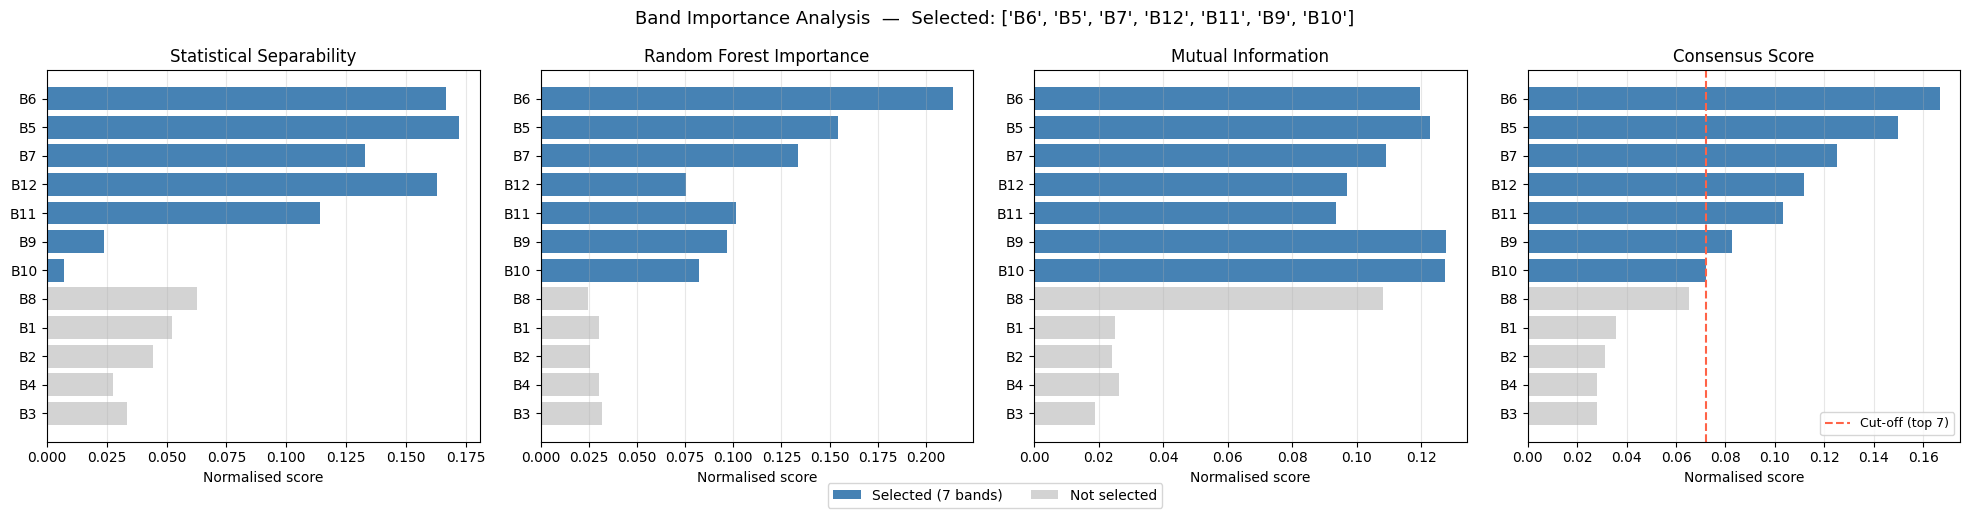

Figure saved -> band_importance.png


In [15]:
# Visualise band importance
colors = ['steelblue' if b in selected_bands_str else 'lightgray'
          for b in consensus['band']]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax, col, title in [
    (axes[0], 'separability',   'Statistical Separability'),
    (axes[1], 'rf_importance',  'Random Forest Importance'),
    (axes[2], 'mutual_info',    'Mutual Information'),
    (axes[3], 'consensus_score','Consensus Score'),
]:
    ax.barh(consensus['band'], consensus[col], color=colors)
    ax.set_title(title)
    ax.invert_yaxis()
    ax.set_xlabel('Normalised score')
    ax.grid(axis='x', alpha=0.3)

axes[3].axvline(
    consensus['consensus_score'].iloc[n_selected - 1],
    color='tomato', linestyle='--', label=f'Cut-off (top {n_selected})'
)
axes[3].legend(fontsize=9)

legend_elements = [
    Patch(facecolor='steelblue', label=f'Selected ({n_selected} bands)'),
    Patch(facecolor='lightgray', label='Not selected'),
]
fig.legend(handles=legend_elements, loc='lower center', ncol=2,
           fontsize=10, bbox_to_anchor=(0.5, -0.03))

plt.suptitle(f'Band Importance Analysis  —  Selected: {selected_bands_str}', fontsize=13)
plt.tight_layout()
plt.savefig('band_importance.png', dpi=120, bbox_inches='tight')
plt.show()
print('Figure saved -> band_importance.png')

## TensorFlow Data Pipeline

The pipeline reads only the selected important bands from each 12-band GeoTIFF,
applies per-band z-score normalization, and augments the training set.

In [17]:
IMG_SIZE      = 128
# NUM_CHANNELS is set by band selection above
BATCH_SIZE    = 8
NUM_EPOCHS    = 50
LEARNING_RATE = 1e-3
VAL_SPLIT     = 0.2
SEED          = 42

print(f"Input bands        : {NUM_CHANNELS}  ->  {selected_bands_str}")
print(f"Band indices (0-ix): {SELECTED_BAND_IDX}")

Input bands        : 7  ->  ['B6', 'B5', 'B7', 'B12', 'B11', 'B9', 'B10']
Band indices (0-ix): [5, 4, 6, 11, 10, 8, 9]


In [18]:
all_imgs = sorted(Path(IMAGES_CLEAN).glob('*.tif'))
all_lbls = [Path(LABELS_CLEAN) / (p.stem + '.png') for p in all_imgs]
assert all(p.exists() for p in all_lbls), "Some labels are missing!"

img_paths = [str(p) for p in all_imgs]
lbl_paths = [str(p) for p in all_lbls]

train_imgs, val_imgs, train_lbls, val_lbls = train_test_split(
    img_paths, lbl_paths, test_size=VAL_SPLIT, random_state=SEED
)
print(f"Dataset  : {len(all_imgs)} samples")
print(f"Train    : {len(train_imgs)}   |   Val: {len(val_imgs)}")

Dataset  : 306 samples
Train    : 244   |   Val: 62


In [19]:
def compute_band_stats(img_list, band_indices, n_samples=50):
    """Compute per-band mean and std for the selected bands from a random subset."""
    sample_list = np.random.choice(img_list, min(n_samples, len(img_list)), replace=False)
    all_data = []
    for path in sample_list:
        with rasterio.open(path) as src:
            arr = src.read()[band_indices].astype(np.float32)  # (K, H, W)
        all_data.append(arr.reshape(len(band_indices), -1))
    all_data = np.concatenate(all_data, axis=1)
    return (all_data.mean(axis=1).astype(np.float32),
            (all_data.std(axis=1) + 1e-8).astype(np.float32))

print("Computing band statistics on selected bands...")
BAND_IDX_NP         = np.array(SELECTED_BAND_IDX)
BAND_MEAN, BAND_STD = compute_band_stats(train_imgs, BAND_IDX_NP)
print(f"Means : {BAND_MEAN.round(2)}")
print(f"Stds  : {BAND_STD.round(2)}")

Computing band statistics on selected bands...
Means : [1794.75 1915.18 1215.46   10.59   35.8   251.74  254.07]
Stds  : [1285.44 1098.96  960.37   28.23   20.93  366.57  366.05]


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:367: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)


In [20]:
_band_mean = tf.constant(BAND_MEAN, dtype=tf.float32)
_band_std  = tf.constant(BAND_STD,  dtype=tf.float32)
_band_idx  = BAND_IDX_NP

def _read_sample(img_path, lbl_path):
    img_path = img_path.numpy().decode('utf-8')
    lbl_path = lbl_path.numpy().decode('utf-8')

    with rasterio.open(img_path) as src:
        arr = src.read().astype(np.float32)   # (12, H, W)
    arr  = arr[_band_idx]                     # (K, H, W)
    arr  = np.transpose(arr, (1, 2, 0))       # (H, W, K)
    arr  = cv2.resize(arr, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)

    mask = cv2.imread(lbl_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    mask = (mask > 0).astype(np.float32)[..., np.newaxis]  # (H, W, 1)
    return arr, mask

def load_sample(img_path, lbl_path):
    img, mask = tf.py_function(
        _read_sample, [img_path, lbl_path], [tf.float32, tf.float32]
    )
    img.set_shape([IMG_SIZE, IMG_SIZE, NUM_CHANNELS])
    mask.set_shape([IMG_SIZE, IMG_SIZE, 1])
    return img, mask

def normalize(img, mask):
    return (img - _band_mean) / _band_std, mask

def augment(img, mask):
    if tf.random.uniform(()) > 0.5:
        img  = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        img  = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)
    k    = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
    img  = tf.image.rot90(img,  k)
    mask = tf.image.rot90(mask, k)
    return img, mask

def make_dataset(img_paths, lbl_paths, augmentation=False, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((img_paths, lbl_paths))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(img_paths), seed=SEED)
    ds = ds.map(load_sample,  num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(normalize,    num_parallel_calls=tf.data.AUTOTUNE)
    if augmentation:
        ds = ds.map(augment,  num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(train_imgs, train_lbls, augmentation=True,  shuffle=True)
val_ds   = make_dataset(val_imgs,   val_lbls,   augmentation=False, shuffle=False)

for x, y in train_ds.take(1):
    print(f"Image batch shape : {x.shape}   dtype={x.dtype}")
    print(f"Mask  batch shape : {y.shape}   dtype={y.dtype}")
    print(f"Mask  unique vals : {np.unique(y.numpy())}")

Image batch shape : (8, 128, 128, 7)   dtype=<dtype: 'float32'>
Mask  batch shape : (8, 128, 128, 1)   dtype=<dtype: 'float32'>
Mask  unique vals : [0. 1.]


## U-Net Architecture (ResNet34-style Encoder)

Full U-Net with a ResNet34-style encoder built from scratch in Keras.
The stem convolution accepts K input channels (K = number of selected bands).

    Stem          : Conv7x7 stride2 -> BN -> ReLU -> MaxPool stride2
    Encoder stage1: 64  filters, 3 residual blocks, stride1
    Encoder stage2: 128 filters, 4 residual blocks, stride2
    Encoder stage3: 256 filters, 6 residual blocks, stride2
    Encoder stage4: 512 filters, 3 residual blocks, stride2
    Bottleneck    : 512 filters x 2 conv blocks
    Decoder       : 4 x (bilinear upsample + skip concat + 2 conv blocks)
    Final         : bilinear upsample x2 + 2 conv blocks + 1x1 sigmoid head

In [21]:
def conv_bn_relu(x, filters, kernel_size=3, strides=1, use_bias=False, name=None):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same',
                      use_bias=use_bias, kernel_initializer='he_normal', name=name)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x


def residual_block(x, filters, strides=1, downsample=False, name_prefix=''):
    shortcut = x

    x = layers.Conv2D(filters, 3, strides=strides, padding='same', use_bias=False,
                      kernel_initializer='he_normal', name=f'{name_prefix}_conv1')(x)
    x = layers.BatchNormalization(name=f'{name_prefix}_bn1')(x)
    x = layers.Activation('relu', name=f'{name_prefix}_relu1')(x)

    x = layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False,
                      kernel_initializer='he_normal', name=f'{name_prefix}_conv2')(x)
    x = layers.BatchNormalization(name=f'{name_prefix}_bn2')(x)

    if downsample or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=strides, padding='same',
                                 use_bias=False, kernel_initializer='he_normal',
                                 name=f'{name_prefix}_shortcut_conv')(shortcut)
        shortcut = layers.BatchNormalization(name=f'{name_prefix}_shortcut_bn')(shortcut)

    x = layers.Add(name=f'{name_prefix}_add')([x, shortcut])
    x = layers.Activation('relu', name=f'{name_prefix}_relu2')(x)
    return x


def make_encoder_stage(x, filters, n_blocks, strides, stage_name):
    x = residual_block(x, filters, strides=strides, downsample=True,
                       name_prefix=f'{stage_name}_block1')
    for i in range(1, n_blocks):
        x = residual_block(x, filters, strides=1, downsample=False,
                           name_prefix=f'{stage_name}_block{i+1}')
    return x


def decoder_block(x, skip, filters, name_prefix=''):
    x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear',
                            name=f'{name_prefix}_upsample')(x)
    if skip is not None:
        x = layers.Concatenate(name=f'{name_prefix}_concat')([x, skip])
    x = conv_bn_relu(x, filters, name=f'{name_prefix}_conv1')
    x = conv_bn_relu(x, filters, name=f'{name_prefix}_conv2')
    return x


    U-Net with ResNet34-style encoder.

    Parameters
    input_channels : int
        Number of input spectral bands (the K selected important bands).
    img_size       : int
        Square spatial size of input patches.
    num_classes    : int
        1 -> binary sigmoid head; >1 -> multi-class softmax head.


In [22]:
def build_unet_resnet34(input_channels, img_size=128, num_classes=1):

    inputs = keras.Input(shape=(img_size, img_size, input_channels), name='input')

    # Stem — adapts to any number of input channels
    x  = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False,
                       kernel_initializer='he_normal', name='stem_conv')(inputs)
    x  = layers.BatchNormalization(name='stem_bn')(x)
    s0 = layers.Activation('relu', name='stem_relu')(x)
    x  = layers.MaxPooling2D(pool_size=3, strides=2, padding='same',
                             name='stem_pool')(s0)

    # Encoder (ResNet34 block counts: 3, 4, 6, 3)
    s1 = make_encoder_stage(x,  filters=64,  n_blocks=3, strides=1, stage_name='enc1')
    s2 = make_encoder_stage(s1, filters=128, n_blocks=4, strides=2, stage_name='enc2')
    s3 = make_encoder_stage(s2, filters=256, n_blocks=6, strides=2, stage_name='enc3')
    s4 = make_encoder_stage(s3, filters=512, n_blocks=3, strides=2, stage_name='enc4')

    # Bottleneck
    b = conv_bn_relu(s4, 512, name='bottleneck_conv1')
    b = conv_bn_relu(b,  512, name='bottleneck_conv2')

    # Decoder with skip connections
    d4 = decoder_block(b,  s3, filters=256, name_prefix='dec4')
    d3 = decoder_block(d4, s2, filters=128, name_prefix='dec3')
    d2 = decoder_block(d3, s1, filters=64,  name_prefix='dec2')
    d1 = decoder_block(d2, s0, filters=32,  name_prefix='dec1')

    # Final upsample back to input resolution
    d0 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear',
                             name='final_upsample')(d1)
    d0 = conv_bn_relu(d0, 32, name='final_conv1')
    d0 = conv_bn_relu(d0, 16, name='final_conv2')

    # Output head
    if num_classes == 1:
        outputs = layers.Conv2D(1, 1, activation='sigmoid', name='output')(d0)
    else:
        outputs = layers.Conv2D(num_classes, 1, activation='softmax', name='output')(d0)

    return Model(inputs=inputs, outputs=outputs,
                 name=f'UNet_ResNet34_{input_channels}ch')


model = build_unet_resnet34(
    input_channels = NUM_CHANNELS,
    img_size       = IMG_SIZE,
    num_classes    = 1,
)

model.summary(line_length=120, expand_nested=False)
print(f"\nInput channels : {NUM_CHANNELS}  {selected_bands_str}")
print(f"Total params   : {model.count_params():,}")

Model: "UNet_ResNet34_7ch"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input (InputLayer)                │ (None, 128, 128, 7)          │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ stem_conv (Conv2D)                │ (None, 64, 64, 64)           │            21,952 │ input[0][0]               
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ stem_bn (BatchNormalization)      │ (None, 64, 64, 64)           │               256 │ stem_conv[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ stem_relu (Activation)            │ (None, 64, 64, 64)           │                 0 │ stem_bn[0][0]             
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ stem_pool (MaxPooling2D)          │ (None, 32, 32, 64)           │                 0 │ stem_relu[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ enc1_block1_conv1 (Conv2D)        │ (None, 32, 32, 64)           │            36,864 │ stem_pool[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ enc1_block1_bn1                   │ (None, 32, 32, 64)           │               256 │ enc1_block1_conv1[0][0]   
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ enc1_block1_relu1 (Activation)    │ (None, 32, 32, 64)           │                 0 │ enc1_block1_bn1[0][0]     
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ enc1_block1_conv2 (Conv2D)        │ (None, 32, 32, 64)           │            36,864 │ enc1_block1_relu1[0][0]   
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ enc1_block1_shortcut_conv         │ (None, 32, 32, 64)           │             4,096 │ stem_pool[0][0]           
│ (Conv2D)                          │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ enc1_block1_bn2                   │ (None, 32, 32, 64)           │               256 │ enc1_block1_conv2[0][0]   
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ enc1_block1_shortcut_bn           │ (None, 32, 32, 64)           │               256 │ enc1_block1_shortcut_conv[
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ enc1_block1_add (Add)             │ (None, 32, 32, 64)           │                 0 │ enc1_block1_bn2[0][0],    
│                                   │                              │                   │ enc1_block1_shortcut_bn[0]
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ enc1_block1_relu2 (Activation)    │ (None, 32, 32, 64)

 Total params: 29,201,809 (111.40 MB)

 Trainable params: 29,180,593 (111.32 MB)

 Non-trainable params: 21,216 (82.88 KB)


Input channels : 7  ['B6', 'B5', 'B7', 'B12', 'B11', 'B9', 'B10']
Total params   : 29,201,809


## Loss Functions and Metrics

Combined Binary Cross-Entropy + Dice Loss (50/50 blend).
All metrics are implemented as custom Keras Metric classes.

In [23]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1.0 - (2.0 * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

def bce_dice_loss(y_true, y_pred):
    bce = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, y_pred))
    return 0.5 * bce + 0.5 * dice_loss(y_true, y_pred)


class BinaryIoU(tf.keras.metrics.Metric):
    def __init__(self, threshold=0.5, name='iou', **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold    = threshold
        self.intersection = self.add_weight(name='inter', initializer='zeros')
        self.union        = self.add_weight(name='union', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        inter  = tf.reduce_sum(y_true * y_pred)
        union  = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - inter
        self.intersection.assign_add(inter)
        self.union.assign_add(union)

    def result(self):
        return (self.intersection + 1e-6) / (self.union + 1e-6)

    def reset_state(self):
        self.intersection.assign(0.)
        self.union.assign(0.)


class BinaryF1(tf.keras.metrics.Metric):
    def __init__(self, threshold=0.5, name='f1', **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        self.tp.assign_add(tf.reduce_sum(y_true * y_pred))
        self.fp.assign_add(tf.reduce_sum((1 - y_true) * y_pred))
        self.fn.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))

    def result(self):
        return (2 * self.tp + 1e-6) / (2 * self.tp + self.fp + self.fn + 1e-6)

    def reset_state(self):
        self.tp.assign(0.); self.fp.assign(0.); self.fn.assign(0.)


class BinaryPrecision(tf.keras.metrics.Metric):
    def __init__(self, threshold=0.5, name='precision', **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        self.tp.assign_add(tf.reduce_sum(y_true * y_pred))
        self.fp.assign_add(tf.reduce_sum((1 - y_true) * y_pred))

    def result(self):
        return (self.tp + 1e-6) / (self.tp + self.fp + 1e-6)

    def reset_state(self):
        self.tp.assign(0.); self.fp.assign(0.)


class BinaryRecall(tf.keras.metrics.Metric):
    def __init__(self, threshold=0.5, name='recall', **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        self.tp.assign_add(tf.reduce_sum(y_true * y_pred))
        self.fn.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))

    def result(self):
        return (self.tp + 1e-6) / (self.tp + self.fn + 1e-6)

    def reset_state(self):
        self.tp.assign(0.); self.fn.assign(0.)


print("Loss functions and custom metrics defined.")

Loss functions and custom metrics defined.


## Compile Model

In [24]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss      = bce_dice_loss,
    metrics   = [
        BinaryIoU(name='iou'),
        BinaryF1(name='f1'),
        BinaryPrecision(name='precision'),
        BinaryRecall(name='recall'),
    ]
)

print(f"Model compiled.")
print(f"Total parameters : {model.count_params():,}")
print(f"Input channels   : {NUM_CHANNELS}  {selected_bands_str}")

Model compiled.
Total parameters : 29,201,809
Input channels   : 7  ['B6', 'B5', 'B7', 'B12', 'B11', 'B9', 'B10']


## Callbacks

In [25]:
best_model_path = f"{OUTPUT_DIR}/best_model.keras"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath       = best_model_path,
        monitor        = 'val_iou',
        mode           = 'max',
        save_best_only = True,
        verbose        = 1,
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor  = 'val_iou',
        mode     = 'max',
        factor   = 0.5,
        patience = 8,
        min_lr   = 1e-6,
        verbose  = 1,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor              = 'val_iou',
        mode                 = 'max',
        patience             = 15,
        restore_best_weights = True,
        verbose              = 1,
    ),
    tf.keras.callbacks.CSVLogger(f"{OUTPUT_DIR}/training_history.csv"),
]

print("Callbacks configured.")

Callbacks configured.


## Train

In [26]:
print("Starting training — U-Net + ResNet34 encoder")
print(f"Input bands  : {NUM_CHANNELS}  {selected_bands_str}")
print(f"Image size   : {IMG_SIZE} x {IMG_SIZE}")
print(f"Batch size   : {BATCH_SIZE}   Epochs: {NUM_EPOCHS}   LR: {LEARNING_RATE}")
print(f"Train set    : {len(train_imgs)} images   Val set: {len(val_imgs)} images")
print("=" * 60)

t0 = time.time()
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs          = NUM_EPOCHS,
    callbacks       = callbacks,
    verbose         = 1,
)
elapsed = time.time() - t0

h = history.history
best_ep = int(np.argmax(h['val_iou']))
print(f"\nTraining complete in {elapsed/60:.1f} min")
print(f"Best model saved -> {best_model_path}")
print(f"\n=== Best Epoch: {best_ep+1} ===")
print(f"  IoU       : {h['val_iou'][best_ep]:.4f}")
print(f"  F1        : {h['val_f1'][best_ep]:.4f}")
print(f"  Precision : {h['val_precision'][best_ep]:.4f}")
print(f"  Recall    : {h['val_recall'][best_ep]:.4f}")
print(f"  Val Loss  : {h['val_loss'][best_ep]:.4f}")

Starting training — U-Net + ResNet34 encoder
Input bands  : 7  ['B6', 'B5', 'B7', 'B12', 'B11', 'B9', 'B10']
Image size   : 128 x 128
Batch size   : 8   Epochs: 50   LR: 0.001
Train set    : 244 images   Val set: 62 images
Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - f1: 0.6357 - iou: 0.4738 - loss: 0.4846 - precision: 0.6276 - recall: 0.6459   
Epoch 1: val_iou improved from -inf to 0.22380, saving model to /content/satellite_data/unet_models/best_model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - f1: 0.6388 - iou: 0.4771 - loss: 0.4821 - precision: 0.6310 - recall: 0.6487 - val_f1: 0.3658 - val_iou: 0.2238 - val_loss: 254860.4219 - val_precision: 0.2243 - val_recall: 0.9900 - learning_rate: 0.0010
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - f1: 0.7794 - iou: 0.6389 - loss: 0.3378 - precision: 0.8212 - recall: 0.7429
Epoch 2: val_iou improved from 0.22380 to 0.22876, saving model to /content/satellite_data/unet_models/best_model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 2

## Training Curves

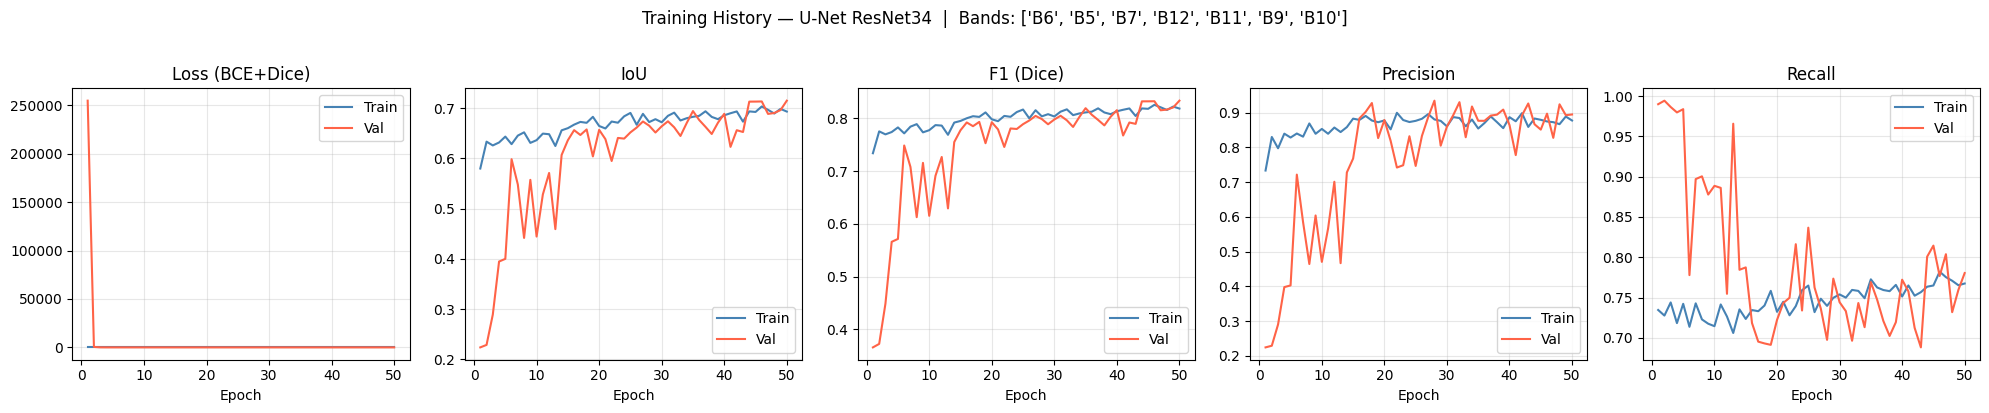

Figure saved -> val_metrics.png


In [27]:
h      = history.history
epochs = range(1, len(h['loss']) + 1)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
pairs = [
    ('loss',      'val_loss',      'Loss (BCE+Dice)'),
    ('iou',       'val_iou',       'IoU'),
    ('f1',        'val_f1',        'F1 (Dice)'),
    ('precision', 'val_precision', 'Precision'),
    ('recall',    'val_recall',    'Recall'),
]
for ax, (tr_key, val_key, title) in zip(axes, pairs):
    ax.plot(epochs, h[tr_key],  label='Train', color='steelblue')
    ax.plot(epochs, h[val_key], label='Val',   color='tomato')
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle(
    f'Training History — U-Net ResNet34  |  Bands: {selected_bands_str}',
    fontsize=12, y=1.02
)
plt.tight_layout()
plt.savefig('val_metrics.png', dpi=120, bbox_inches='tight')
plt.show()
print('Figure saved -> val_metrics.png')

In [28]:
df = pd.read_csv(f"{OUTPUT_DIR}/training_history.csv")
df['epoch'] = df['epoch'] + 1

print("\n=== Performance Metrics Summary ===")
print(f"IoU       - Best: {df['val_iou'].max():.4f} | Final: {df['val_iou'].iloc[-1]:.4f}")
print(f"F1        - Best: {df['val_f1'].max():.4f} | Final: {df['val_f1'].iloc[-1]:.4f}")
print(f"Precision - Best: {df['val_precision'].max():.4f} | Final: {df['val_precision'].iloc[-1]:.4f}")
print(f"Recall    - Best: {df['val_recall'].max():.4f} | Final: {df['val_recall'].iloc[-1]:.4f}")
print(f"Val Loss  - Best: {df['val_loss'].min():.4f}  | Final: {df['val_loss'].iloc[-1]:.4f}")
print("===================================")

display_cols = ['epoch', 'loss', 'val_loss', 'val_iou', 'val_f1', 'val_precision', 'val_recall']
df[[c for c in display_cols if c in df.columns]]


=== Performance Metrics Summary ===
IoU       - Best: 0.7150 | Final: 0.7150
F1        - Best: 0.8338 | Final: 0.8338
Precision - Best: 0.9348 | Final: 0.8950
Recall    - Best: 0.9944 | Final: 0.7804
Val Loss  - Best: 0.2098  | Final: 0.2149


,epoch,loss,val_loss,val_iou,val_f1,val_precision,val_recall
0,1,0.404234,254860.421875,0.223803,0.365750,0.224311,0.989979
1,2,0.336707,490.935577,0.228759,0.372342,0.229055,0.994379
2,3,0.325172,42.709686,0.289131,0.448567,0.290278,0.986512
3,4,0.316638,4.468065,0.394680,0.565980,0.397919,0.979795
4,5,0.298621,2.778409,0.400070,0.571500,0.402718,0.983827
5,6,0.307018,0.302760,0.598450,0.748788,0.721841,0.777824
6,7,0.298963,0.645636,0.548071,0.708069,0.584871,0.897018
7,8,0.288632,0.606037,0.441733,0.612781,0.464411,0.900458
8,9,0.302253,0.361182,0.557329,0.715750,0.604195,0.877827
9,10,0.297354,0.646538,0.444432,0.615373,0.470643,0.888647


In [30]:
best_model = tf.keras.models.load_model(
    best_model_path,
    custom_objects={
        'bce_dice_loss'   : bce_dice_loss,
        'BinaryIoU'       : BinaryIoU,
        'BinaryF1'        : BinaryF1,
        'BinaryPrecision' : BinaryPrecision,
        'BinaryRecall'    : BinaryRecall,
    }
)

TEST_IDX   = 3
clean_imgs = sorted(Path(IMAGES_CLEAN).glob('*.tif'))
clean_lbls = sorted(Path(LABELS_CLEAN).glob('*.png'))

PRED_DIR = '/content/satellite_data/predictions'
Path(PRED_DIR).mkdir(parents=True, exist_ok=True)
prediction_path = f"{PRED_DIR}/pred_{clean_imgs[TEST_IDX].stem}.png"

# Read selected bands only
with rasterio.open(str(clean_imgs[TEST_IDX])) as src:
    raw = src.read().astype(np.float32)    # (12, H, W)
raw = raw[BAND_IDX_NP]                     # (K, H, W)
raw = np.transpose(raw, (1, 2, 0))         # (H, W, K)

t_inf = time.time()
pred_mask = predict_sliding_window(
    best_model, raw, BAND_MEAN, BAND_STD,
    window_size=IMG_SIZE, overlap=32, threshold=0.5
)
t_inf = time.time() - t_inf

cv2.imwrite(prediction_path, pred_mask * 255)
print(f"Inference time   : {t_inf:.3f}s")
print(f"Predicted water  : {pred_mask.mean()*100:.1f}%")
print(f"Prediction saved -> {prediction_path}")

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:367: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)


Inference time   : 4.356s
Predicted water  : 36.1%
Prediction saved -> /content/satellite_data/predictions/pred_100.png


## Visualize Results

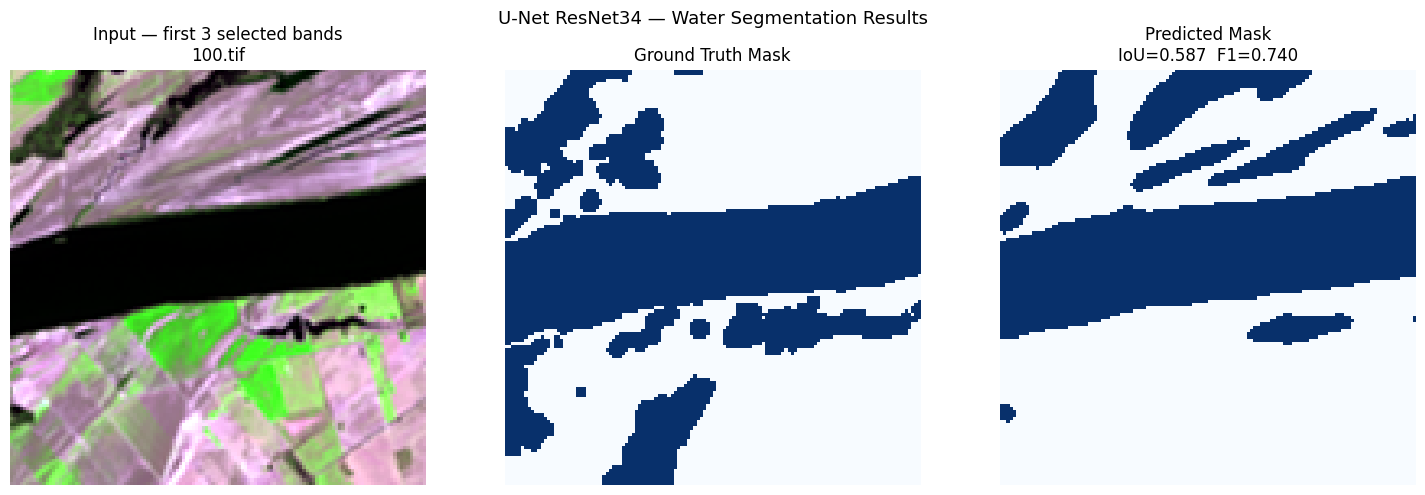

Plot saved to: /content/satellite_data/predictions/comparison_3.png


In [31]:
gt_mask = cv2.imread(str(clean_lbls[TEST_IDX]), cv2.IMREAD_GRAYSCALE)
gt_mask = (gt_mask > 0).astype(np.uint8)

# Pseudo-RGB from first three selected bands
rgb = raw[..., :3].copy()
for c in range(3):
    p2, p98 = np.percentile(rgb[..., c], [2, 98])
    rgb[..., c] = np.clip((rgb[..., c] - p2) / (p98 - p2 + 1e-8), 0, 1)

# Per-sample metrics
gt_f = gt_mask.astype(float).ravel()
pr_f = pred_mask.astype(float).ravel()
tp   = (gt_f * pr_f).sum()
fp   = ((1 - gt_f) * pr_f).sum()
fn   = (gt_f * (1 - pr_f)).sum()
iou_val = tp / (tp + fp + fn + 1e-8)
f1_val  = 2 * tp / (2 * tp + fp + fn + 1e-8)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(rgb)
axes[0].set_title(
    f'Input — first 3 selected bands\n{clean_imgs[TEST_IDX].stem}.tif'
)
axes[1].imshow(gt_mask,   cmap='Blues', vmin=0, vmax=1)
axes[1].set_title('Ground Truth Mask')
axes[2].imshow(pred_mask, cmap='Blues', vmin=0, vmax=1)
axes[2].set_title(f'Predicted Mask\nIoU={iou_val:.3f}  F1={f1_val:.3f}')
for ax in axes:
    ax.axis('off')

plt.suptitle('U-Net ResNet34 — Water Segmentation Results', fontsize=13)
plt.tight_layout()
save_path = f"{PRED_DIR}/comparison_{TEST_IDX}.png"
plt.savefig(save_path, dpi=120, bbox_inches='tight')
plt.show()
print(f"Plot saved to: {save_path}")

## Batch Evaluation on Validation Set

In [33]:
print("Evaluating best model on full validation set...")
val_results = best_model.evaluate(val_ds, verbose=1)

metric_names = ['loss', 'iou', 'f1', 'precision', 'recall']
print("\n=== Validation Results ===")
for name, val in zip(metric_names, val_results):
    print(f"  {name:12s}: {val:.4f}")

Evaluating best model on full validation set...
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 463ms/step - f1: 0.8098 - iou: 0.6810 - loss: 0.2241 - precision: 0.8693 - recall: 0.7581

=== Validation Results ===
  loss        : 0.2149
  iou         : 0.7150
  f1          : 0.8338
  precision   : 0.8950
  recall      : 0.7804


## Save Outputs to Google Drive

In [37]:
drive_out = Path('/content/drive/MyDrive/water_seg_tensorflow')
drive_out.mkdir(parents=True, exist_ok=True)

files_to_save = [
    best_model_path,
    f"{OUTPUT_DIR}/training_history.csv",
    'band_importance.png',
    'band_distributions.png',
    'val_metrics.png',
    f"{PRED_DIR}/comparison_{TEST_IDX}.png",
    f"{PRED_DIR}/overlay_{TEST_IDX}.png",
]

for src_path in files_to_save:
    if Path(src_path).exists():
        shutil.copy(src_path, drive_out / Path(src_path).name)
        print(f"Saved -> {drive_out / Path(src_path).name}")
    else:
        print(f"Not found: {src_path}")

# Save band selection summary as CSV
consensus.to_csv(drive_out / 'band_importance_ranking.csv', index=False)
print(f"Band ranking CSV -> {drive_out / 'band_importance_ranking.csv'}")
print(f"\nAll outputs saved to: {drive_out}")

Saved -> /content/drive/MyDrive/water_seg_tensorflow/best_model.keras
Saved -> /content/drive/MyDrive/water_seg_tensorflow/training_history.csv
Saved -> /content/drive/MyDrive/water_seg_tensorflow/band_importance.png
Saved -> /content/drive/MyDrive/water_seg_tensorflow/band_distributions.png
Saved -> /content/drive/MyDrive/water_seg_tensorflow/val_metrics.png
Saved -> /content/drive/MyDrive/water_seg_tensorflow/comparison_3.png
Saved -> /content/drive/MyDrive/water_seg_tensorflow/overlay_3.png
Band ranking CSV -> /content/drive/MyDrive/water_seg_tensorflow/band_importance_ranking.csv

All outputs saved to: /content/drive/MyDrive/water_seg_tensorflow
